In [26]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
#from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## Tweets

In [9]:
import pandas as pd

df = pd.read_csv('./data/hate-speech/haspeede_TW-train.tsv',sep='\t', names=['ID','Text','Label'])
df.head()

,ID,Text,Label
0,576268275560116224,@matteorenzi ...all'invasione di questi animal...,1
1,815833978691260416,"È terrorismo anche questo, per mettere in uno ...",0
2,815112299044372480,@Nanoalto @FedeAngeli infatti finché ci hanno ...,0
3,577451440047853568,@dinofarnesi Piovegovernolad In Italia a...,1
4,844921803575382016,#londonattack chiedete ai buonisti del cavolo ...,1


## Inizio analisi

Counts of positive matches and negative ones

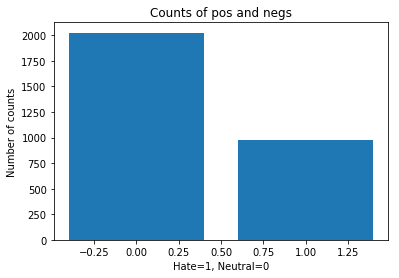

In [18]:
pos_neg_cnt = df.Label.value_counts()

plt.ylabel("Number of counts")
plt.xlabel("Hate=1, Neutral=0")
plt.title("Counts of pos and negs")
plt.bar(pos_neg_cnt.index,pos_neg_cnt.values)
plt.show()

Statistics on average sequence length

In [21]:
df["tw_length"] = df["Text"].str.len()
df["tw_length"].describe()

count    2998.000000
mean      120.808539
std        21.898270
min        16.000000
25%       109.000000
50%       129.000000
75%       138.000000
max       298.000000
Name: tw_length, dtype: float64

In [43]:
df["tw_w_len"] = df['Text'].str.split().apply(len)
df["tw_w_len"].describe()

count    2998.000000
mean       16.984656
std         4.264655
min         2.000000
25%        14.000000
50%        17.000000
75%        20.000000
max        45.000000
Name: tw_w_len, dtype: float64

Some plots: distribution of tweets length

(array([   8.,  107.,  450.,  895., 1536.,    0.,    0.,    0.,    0.,
           2.]),
 array([ 16. ,  44.2,  72.4, 100.6, 128.8, 157. , 185.2, 213.4, 241.6,
        269.8, 298. ]),
 <a list of 10 Patch objects>)

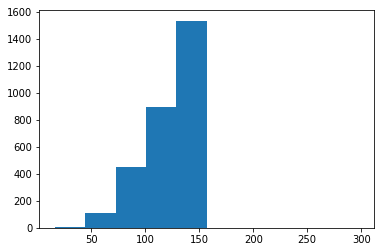

In [46]:
plt.hist(df["tw_length"])

Seems that we have not so many tweets beyond 144 chars

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([153. , 167.5, 182. , 196.5, 211. , 225.5, 240. , 254.5, 269. ,
        283.5, 298. ]),
 <a list of 10 Patch objects>)

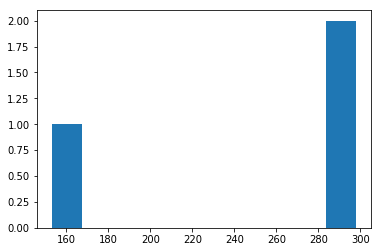

In [39]:
plt.hist(df.query("tw_length >= 144")["tw_length"])

(array([2.400e+01, 1.950e+02, 6.010e+02, 1.305e+03, 7.160e+02, 1.510e+02,
        4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([ 2. ,  6.3, 10.6, 14.9, 19.2, 23.5, 27.8, 32.1, 36.4, 40.7, 45. ]),
 <a list of 10 Patch objects>)

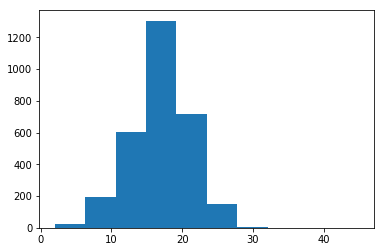

In [49]:
plt.hist(df["tw_w_len"])

(array([3., 1., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([28. , 29.7, 31.4, 33.1, 34.8, 36.5, 38.2, 39.9, 41.6, 43.3, 45. ]),
 <a list of 10 Patch objects>)

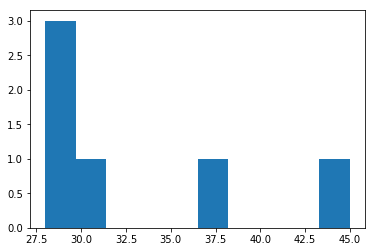

In [54]:
plt.hist(df.query("tw_w_len > 27")["tw_w_len"])

Seems that tweets beyond 27 words are not so common

In [60]:
from collections import Counter
import numpy as np

def count_words(data,textCol="Text",labelCol="Label"):
    
    neutral_counts = Counter()
    hate_counts = Counter()
    total_counts = Counter()

    for index, row in data.iterrows():
        if(row[labelCol] == 1):
            for word in row[textCol].split(" "):
                hate_counts[word] += 1
                total_counts[word] += 1
        else:
            for word in row[textCol].split(" "):
                neutral_counts[word] += 1
                total_counts[word] += 1
    return neutral_counts, hate_counts, total_counts

In [61]:
neutral, positive, total = count_words(data=df, textCol="Text", labelCol="Label")
positive.most_common()

[('', 600),
 ('e', 404),
 ('di', 389),
 ('i', 348),
 ('che', 302),
 ('a', 282),
 ('in', 264),
 ('tutti', 217),
 ('non', 199),
 ('la', 184),
 ('sono', 177),
 ('gli', 162),
 ('il', 157),
 ('per', 152),
 ('è', 134),
 ('con', 110),
 ('un', 109),
 ('da', 101),
 ('immigrati', 96),
 ('si', 95),
 ('le', 95),
 ('rom', 95),
 ('della', 85),
 ('ci', 82),
 ('anche', 80),
 ('Italia', 77),
 ('islamici', 76),
 ('terroristi', 75),
 ('ma', 73),
 ('musulmani', 73),
 ('loro', 73),
 ('dei', 71),
 ('alla', 67),
 ('fare', 66),
 ('se', 64),
 ('al', 58),
 ('migranti', 52),
 ('come', 52),
 ('una', 51),
 ('casa', 50),
 ('del', 47),
 ('italiani', 47),
 ('tutto', 46),
 ('ai', 45),
 ('stranieri', 44),
 ('li', 44),
 ('lo', 44),
 ('ha', 44),
 ('solo', 42),
 ('agli', 41),
 ('I', 41),
 ('@matteosalvinimi', 40),
 ('più', 39),
 ('questi', 38),
 ('o', 38),
 ('E', 36),
 ('bene', 35),
 ('hanno', 35),
 ('ancora', 35),
 ('chi', 34),
 ('x', 32),
 ('Ma', 32),
 ('profughi', 31),
 ('La', 31),
 ('via', 30),
 ('Non', 29),
 ('noi', 

Seems clear that stopwords are ruining the party here...lets try to address this issue

## STOPWORDS

Different stopwords dictionaries are available in Italy...lets compare them. Gensim is a std library. Imported it just to see if Italian vocab was good enough

In [108]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [174]:
from string import punctuation
import pandas as pd
from nltk.corpus import stopwords

print("NLTK")
nltk_stopwords = stopwords.words('italian')
print("NLTK Len",len(nltk_stopwords))


eva_df = pd.read_csv('./data/stopwords/IT-EVALITA16-stopwords.txt',names=['stopword'],encoding='utf_8')
print("EVALITA len:",eva_df.shape[0])

iso_df = pd.read_csv('./data/stopwords/IT-stopwordsISO-stopwords.txt',names=['stopword'],encoding='utf_8')
print("ISO len:",iso_df.shape[0])

NLTK
NLTK Len 279
EVALITA len: 546
ISO len: 660


Lets find how many word they have in common and which are proprietary

In [175]:
common_sw = pd.merge(eva_df, iso_df, how='inner', on=['stopword', 'stopword'])
iso_additional_words = iso_df[(~iso_df.stopword.isin(common_sw.stopword))]
eva_additional_words = eva_df[(~eva_df.stopword.isin(common_sw.stopword))]
print("Common count:",common_sw.shape[0])
print("Iso additional count:",iso_additional_words.shape[0])
print("Evalita additional count:",eva_additional_words.shape[0])
eva_additional_words.head()

Common count: 528
Iso additional count: 132
Evalita additional count: 18


,stopword
4,ahimÃ¨
37,ciÃ²
39,cioÃ¨
42,cittÃ
57,cosÃ¬


In [92]:
encodings = [
    'ascii',
'big5',
'big5hkscs',
'cp037',
'cp273',
'cp424',
'cp437',
'cp500',
'cp720',
'cp737',
'cp775',
'cp850',
'cp852',
'cp855',
'cp856',
'cp857',
'cp858',
'cp860',
'cp861',
'cp862',
'cp863',
'cp864',
'cp865',
'cp866',
'cp869',
'cp874',
'cp875',
'cp932',
'cp949',
'cp950',
'cp1006',
'cp1026',
'cp1125',
'cp1140',
'cp1250',
'cp1251',
'cp1252',
'cp1253',
'cp1254',
'cp1255',
'cp1256',
'cp1257',
'cp1258',
'cp65001',
'euc_jp',
'euc_jis_2004',
'euc_jisx0213',
'euc_kr',
'gb2312',
'gbk',
'gb18030',
'hz',
'iso2022_jp',
'iso2022_jp_1',
'iso2022_jp_2',
'iso2022_jp_2004',
'iso2022_jp_3',
'iso2022_jp_ext',
'iso2022_kr',
'latin_1',
'iso8859_2',
'iso8859_3',
'iso8859_4',
'iso8859_5',
'iso8859_6',
'iso8859_7',
'iso8859_8',
'iso8859_9',
'iso8859_10',
'iso8859_11',
'iso8859_13',
'iso8859_14',
'iso8859_15',
'iso8859_16',
'johab',
'koi8_r',
'koi8_t',
'koi8_u',
'kz1048',
'mac_cyrillic',
'mac_greek',
'mac_iceland',
'mac_latin2',
'mac_roman',
'mac_turkish',
'ptcp154',
'shift_jis',
'shift_jis_2004',
'shift_jisx0213',
'utf_32',
'utf_32_be',
'utf_32_le',
'utf_16',
'utf_16_be',
'utf_16_le',
'utf_7',
'utf_8',
'utf_8_sig'
]

In [104]:
for enc in encodings:
    try:
        print(enc,
              pd.read_csv('./data/stopwords/IT-stopwordsISO-stopwords.txt',names=['stopword'],encoding=enc)[13:14])
    except:
        pass

cp037     stopword
13  /ÇÑ_CtBy
cp273     stopword
13  /ÇÑ_CtBy
cp437     stopword
13  ahim├ú┬¿
cp500     stopword
13  /ÇÑ_CtBy
cp720     stopword
13  ahim├ث┬ذ
cp737     stopword
13  ahim├μ┬ρ
cp775     stopword
13  ahim├Ż┬©
cp850     stopword
13  ahim├ú┬¿
cp852     stopword
13  ahim├ú┬Ę
cp855     stopword
13  ahim├Б┬е
cp857     stopword
13  ahim├ú┬¿
cp858     stopword
13  ahim├ú┬¿
cp860     stopword
13  ahim├ú┬¿
cp861     stopword
13  ahim├ú┬¿
cp862     stopword
13  ahim├ú┬¿
cp863     stopword
13  ahim├ú┬Î
cp864     stopword
13  ahimﺃ£ﺁﺎ
cp865     stopword
13  ahim├ú┬¿
cp866     stopword
13  ahim├г┬и
cp869     stopword
13  ahim├ύ┬Ε
cp874     stopword
13  ahimรฃยจ
cp875     stopword
13  /ΪΫ_CtBy
cp932     stopword
13  ahimﾃ｣ﾂｨ
cp949    stopword
13   ahim찾짢
cp1006     stopword
13  ahimﺣ۲ﺡ۷
cp1026     stopword
13  /[Ñ_CtBy
cp1125     stopword
13  ahim├г┬и
cp1140     stopword
13  /ÇÑ_CtBy
cp1250     stopword
13  ahimĂŁÂ¨
cp1251     stopword
13  ahimГЈВЁ
cp1252     stopword
13  ahimÃ£Â¨
cp1

removing stop words, punctuation and other weird characters

In [177]:
import re

punctuation = r"""!"#$%&'()*+,-–./:;<=>?@[\]^_’`“{|}~"""

FLAGS = re.MULTILINE | re.DOTALL

def substitute_chars(row,stopwords):
    
    text = row["Text"]
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"
    
    def hashtag(text):
        text = text.group()
        hashtag_body = text[1:]
        return hashtag_body
    
    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "")
    text = re_sub(r"/","")
    text = re_sub(r"@\w+", "")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<NHZSMILE>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<NHZLOLFACE>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<NHZSADFACE>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<NHZNEUTRALFACE>")
    text = re_sub(r"<3","<NHZ_HEART>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<NHZNUMBERS>")
    text = re_sub(r"#\S+", hashtag)
    text = re_sub(r"([!?.]){2,}", "")
    #text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <NHZ_ELONG>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    #text = re_sub(r"([A-Z]){2,}", allcaps)
    
    #text = ''.join([c for c in text if c not in punctuation])
    
    #remove punctuation
    #text_no_punct = ''
    #for c in text:
    #    if c not in punctuation:
    #        text_no_punct += c
    #    else:
    #        text_no_punct += ' '
    #text = text_no_punct
    
    words = re.findall(r'[a-z]+', text.lower())
    text = ' '.join(words)
    
    
    #remove stopwords
    words = text.split()
    words = [word for word in words if word not in stopwords]
    text = ' '.join(words)
    
    return text

pd.set_option('display.max_colwidth',1000)

#df["cleaned_text"] = substitute_chars(row['Text'])
sw = nltk_stopwords#iso_df.as_matrix(columns=["stopword"])
df["cleaned_text"] = df.apply(lambda row: substitute_chars(row,sw),axis=1)


In [178]:
df.head(30)

,ID,Text,Label,tw_length,tw_w_len,cleaned_text,sda
0,576268275560116224,"@matteorenzi ...all'invasione di questi animali, e forse è un offesa agli animali, stranieri che arrivano in Italia e solo in Italia?...",1,137,21,invasione animali forse offesa animali stranieri arrivano italia solo italia,nhz allcasdasapsuser allcasdasaps allinvasione di questi animali e forse è un offesa agli animali stranieri che arrivano in italia e solo in italia
1,815833978691260416,"È terrorismo anche questo, per mettere in uno stato di soggezione le persone e renderle innocue, mentre qualcuno... https://t.co/GFAvh0QLe5",0,139,19,terrorismo mettere stato soggezione persone renderle innocue mentre qualcuno,è terrorismo anche questo per mettere in uno stato di soggezione le persone e renderle innocue mentre qualcuno url
2,815112299044372480,@Nanoalto @FedeAngeli infatti finché ci hanno guadagnato con i campi #rom tutto era ok con #Alemanno #Ipocriti,0,110,17,infatti finch guadagnato campi rom ok alemanno ipocriti,nhz allcasdasapsuser allcasdasaps nhz allcasdasapsuser allcasdasaps infatti finché ci hanno guadagnato con i campi hashtag tutto era ok con hashtag hashtag
3,577451440047853568,"@dinofarnesi Piovegovernolad In Italia agli stranieri gli si da anche il culo!!!! Va bene che in molti ci mangiano sopra,ma gli altri.",1,141,22,piovegovernolad italia stranieri culo va bene molti mangiano sopra altri,nhz allcasdasapsuser allcasdasaps piovegovernolad nhz allcasdasapselong allcasdasapsin italia nhz allcasdasapselong allcasdasapsagli stranieri gli si da anche il culo va bene che in molti ci mangiano soprama gli altri
4,844921803575382016,#londonattack chiedete ai buonisti del cavolo cosa vogliono fare con i islamici perché io se chiedo mi vengono solo insulti sulla bocca,1,135,22,londonattack chiedete buonisti cavolo cosa vogliono fare islamici perch chiedo vengono solo insulti bocca,hashtag chiedete ai buonisti del cavolo cosa vogliono fare con i islamici perché io se chiedo mi vengono solo insulti sulla bocca
5,811099342593462272,"Corriere: Tangenti, Mafia Capitale dimenticataMazzette su buche e campi rom https://t.co/RTPu3LNTzF #roma",0,105,12,corriere tangenti mafia capitale dimenticatamazzette buche campi rom roma,corriere tangenti mafia capitale dimenticatamazzette su buche e campi rom url hashtag
6,833323806873833473,"@Pontifex_it ad uno ad uno, perché quando i migranti israeliti arrivarono in terra di Canaan fecero fuori tutti i Canaaniti.",0,124,20,perch quando migranti israeliti arrivarono terra canaan fuori canaaniti,nhz allcasdasapsuser allcasdasaps ad uno ad uno perché quando i migranti israeliti arrivarono in terra di canaan fecero fuori tutti i canaaniti
7,835493194796314624,Il divertimento del giorno? Trovare i patrioti italiani che inneggiano contro i rom facendo la spesa alla #Lidl (multinazionale tedesca).,0,137,20,divertimento giorno trovare patrioti italiani inneggiano rom spesa lidl multinazionale tedesca,il divertimento del giorno trovare i patrioti italiani che inneggiano contro i rom facendo la spesa alla hashtag multinazionale tedesca
8,839605324684361730,Modena: Comune paga la benzina ai nomadi che portano figli a scuola: MODENA – La giunta PD… https://t.co/FwP6n7C5Gi,0,115,18,modena comune paga benzina nomadi portano figli scuola modena giunta pd,modena comune paga la benzina ai nomadi che portano figli a scuola modena allcasdasaps – la giunta pd allcasdasaps… url
9,851906322283016192,"@Cartabiancarai3 @KhalidChaouki3 altro che islam o cristianesimo!!! ...a c dobbiamo sorbire anche ""dell'ignorante"" : islam è uno solo!!",0,136,18,altro islam cristianesimo dobbiamo sorbire ignorante islam solo,nhz allcasdasapsuser allcasdasaps nhz allcasdasapsuser allcasdasaps altro che islam o cristianesimo a c dobbiamo sorbire anche dellignorante islam è uno solo


(array([4.100e+01, 2.680e+02, 7.590e+02, 1.103e+03, 6.640e+02, 1.480e+02,
        1.200e+01, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([  8.,  28.,  48.,  68.,  88., 108., 128., 148., 168., 188., 208.]),
 <a list of 10 Patch objects>)

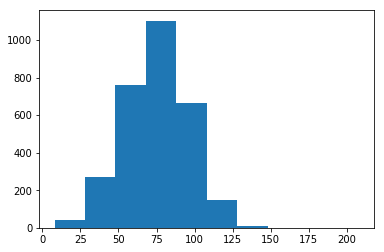

In [204]:
df["cln_w_len"] = df['cleaned_text'].str.split().apply(len)
df["cln_char_len"] = df['cleaned_text'].str.len()
plt.hist(df.query("cln_char_len > 0")["cln_char_len"])

In [180]:
neutral_count, hate_count, total_count = count_words(data=df, textCol="cleaned_text", labelCol="Label")

In [181]:
neutral_count.most_common()

[('rom', 870),
 ('nhznumbers', 495),
 ('roma', 415),
 ('italia', 257),
 ('migranti', 233),
 ('campo', 201),
 ('nomadi', 195),
 ('via', 146),
 ('milano', 122),
 ('immigrati', 119),
 ('campi', 114),
 ('dopo', 91),
 ('stranieri', 86),
 ('terrorismo', 84),
 ('news', 80),
 ('due', 79),
 ('fatto', 77),
 ('profughi', 73),
 ('italiani', 70),
 ('fare', 70),
 ('solo', 67),
 ('immigrazione', 62),
 ('pi', 61),
 ('terroristi', 59),
 ('cinese', 58),
 ('casa', 57),
 ('ancora', 54),
 ('perch', 52),
 ('anni', 50),
 ('morta', 49),
 ('nomade', 49),
 ('scuola', 48),
 ('raggi', 47),
 ('no', 46),
 ('d', 45),
 ('x', 41),
 ('trump', 41),
 ('terrorista', 40),
 ('ora', 37),
 ('grazie', 36),
 ('cosa', 35),
 ('bene', 35),
 ('fa', 35),
 ('oggi', 33),
 ('musulmani', 32),
 ('euro', 32),
 ('polizia', 31),
 ('nhzsmile', 31),
 ('islamici', 31),
 ('it', 30),
 ('notizie', 30),
 ('dallavostraparte', 30),
 ('lidl', 29),
 ('pd', 29),
 ('islam', 29),
 ('salvini', 29),
 ('studentessa', 29),
 ('poi', 28),
 ('clandestini', 28),

In [182]:
hate_count.most_common()

[('italia', 240),
 ('nhznumbers', 165),
 ('immigrati', 153),
 ('rom', 141),
 ('terroristi', 117),
 ('islamici', 108),
 ('musulmani', 104),
 ('migranti', 91),
 ('italiani', 82),
 ('fare', 75),
 ('islam', 67),
 ('stranieri', 62),
 ('casa', 59),
 ('basta', 54),
 ('solo', 52),
 ('clandestini', 52),
 ('via', 50),
 ('profughi', 50),
 ('perch', 47),
 ('bene', 45),
 ('pi', 43),
 ('ancora', 42),
 ('x', 37),
 ('roma', 35),
 ('europa', 34),
 ('no', 33),
 ('immigrazione', 31),
 ('ora', 30),
 ('fatto', 30),
 ('essere', 30),
 ('dopo', 30),
 ('islamica', 29),
 ('mussulmani', 29),
 ('invasione', 27),
 ('cazzo', 27),
 ('senza', 26),
 ('altri', 25),
 ('sempre', 25),
 ('fa', 25),
 ('paese', 25),
 ('quando', 25),
 ('fuori', 24),
 ('islamico', 24),
 ('cosa', 23),
 ('vogliono', 23),
 ('poi', 23),
 ('grazie', 22),
 ('vita', 22),
 ('merda', 22),
 ('prima', 22),
 ('d', 22),
 ('dallavostraparte', 22),
 ('soldi', 21),
 ('pd', 21),
 ('anni', 19),
 ('zingari', 19),
 ('sti', 19),
 ('qui', 19),
 ('forza', 19),
 ('nn

doesn't seem we did a good job...let's tune little bit more the dictionary

In [184]:
pos_neg_ratios = Counter()

for term,cnt in list(total_count.most_common()):
    if(cnt > 30):
        pos_neg_ratio = neutral_count[term] / float(hate_count[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio

In [185]:
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)
    
pos_neg_ratios.most_common()

[('news', 3.6888794541139363),
 ('nomade', 3.1986731175506815),
 ('cinese', 2.9618307218783095),
 ('campo', 2.4700915640028596),
 ('raggi', 2.463853240590168),
 ('roma', 2.4447595817745884),
 ('nomadi', 2.4397862145075306),
 ('polizia', 2.3353749158170367),
 ('trump', 2.327277705584417),
 ('morta', 2.2823823856765264),
 ('milano', 2.23907168727172),
 ('nhzsmile', 2.0476928433652555),
 ('due', 1.9715525796686508),
 ('terrorismo', 1.9459101490553132),
 ('campi', 1.9029851043382795),
 ('rom', 1.8126661540473687),
 ('scuola', 1.791759469228055),
 ('lidl', 1.7578579175523736),
 ('it', 1.3217558399823195),
 ('mila', 1.3121863889661687),
 ('comune', 1.1786549963416462),
 ('euro', 1.1631508098056809),
 ('nhznumbers', 1.092569974212147),
 ('dopo', 1.076872302031704),
 ('via', 1.0517809889840106),
 ('terrorista', 1.0498221244986776),
 ('bambini', 0.9808292530117262),
 ('migranti', 0.9292498765166602),
 ('anni', 0.9162907318741551),
 ('fatto', 0.9098182173685376),
 ('oggi', 0.8574502318512216),
 

# let's try an old NN I had

In [191]:
import time
import sys
import numpy as np

# Encapsulate our neural network in a class
class SentimentNetwork:
    ## New for Project 6: added min_count and polarity_cutoff parameters
    def __init__(self, reviews,labels,min_count = 10,polarity_cutoff = 0.1,hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            min_count(int) - Words should only be added to the vocabulary 
                             if they occur more than this many times
            polarity_cutoff(float) - The absolute value of a word's positive-to-negative
                                     ratio must be at least this big to be considered.
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        
        """
        # Assign a seed to our random number generator to ensure we get
        # reproducable results during development 
        np.random.seed(1)

        # process the reviews and their associated labels so that everything
        # is ready for training
        ## New for Project 6: added min_count and polarity_cutoff arguments to pre_process_data call
        self.pre_process_data(reviews, labels, polarity_cutoff, min_count)
        
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    ## New for Project 6: added min_count and polarity_cutoff parameters
    def pre_process_data(self, reviews, labels, polarity_cutoff, min_count):
        
        ## ----------------------------------------
        ## New for Project 6: Calculate positive-to-negative ratios for words before
        #                     building vocabulary
        #
        positive_counts = Counter()
        negative_counts = Counter()
        total_counts = Counter()

        for i in range(len(reviews)):
            if(labels[i] == 1):
                for word in reviews[i].split(" "):
                    positive_counts[word] += 1
                    total_counts[word] += 1
            else:
                for word in reviews[i].split(" "):
                    negative_counts[word] += 1
                    total_counts[word] += 1

        pos_neg_ratios = Counter()

        for term,cnt in list(total_counts.most_common()):
            if(cnt >= 50):
                pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
                pos_neg_ratios[term] = pos_neg_ratio

        for word,ratio in pos_neg_ratios.most_common():
            if(ratio > 1):
                pos_neg_ratios[word] = np.log(ratio)
            else:
                pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))
        #
        ## end New for Project 6
        ## ----------------------------------------

        # populate review_vocab with all of the words in the given reviews
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                ## New for Project 6: only add words that occur at least min_count times
                #                     and for words with pos/neg ratios, only add words
                #                     that meet the polarity_cutoff
                if(total_counts[word] > min_count):
                    if(word in pos_neg_ratios.keys()):
                        if((pos_neg_ratios[word] >= polarity_cutoff) or (pos_neg_ratios[word] <= -polarity_cutoff)):
                            review_vocab.add(word)
                    else:
                        review_vocab.add(word)

        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        # populate label_vocab with all of the words in the given labels.
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i

    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize weights

        # These are the weights between the input layer and the hidden layer.
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))

        # These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        ## New for Project 5: Removed self.layer_0; added self.layer_1
        # The input layer, a two-dimensional matrix with shape 1 x hidden_nodes
        self.layer_1 = np.zeros((1,hidden_nodes))
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        return output * (1 - output)
    
    ## New for Project 5: changed name of first parameter form 'training_reviews' 
    #                     to 'training_reviews_raw'
    def train(self, training_reviews_raw, training_labels):

        ## New for Project 5: pre-process training reviews so we can deal 
        #                     directly with the indices of non-zero inputs
        training_reviews = list()
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                if(word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))

        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0

        # Remember when we started for printing time statistics
        start = time.time()
        
        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            #### Implement the forward pass here ####
            ### Forward pass ###

            ## New for Project 5: Removed call to 'update_input_layer' function
            #                     because 'layer_0' is no longer used

            # Hidden layer
            ## New for Project 5: Add in only the weights for non-zero items
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]

            # Output layer
            ## New for Project 5: changed to use 'self.layer_1' instead of 'local layer_1'
            layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))            
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # Output error
            layer_2_error = layer_2 - label # Output layer error is the difference between desired target and actual output.
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)

            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errors propagated to the hidden layer
            layer_1_delta = layer_1_error # hidden layer gradients - no nonlinearity so it's the same as the error

            # Update the weights
            ## New for Project 5: changed to use 'self.layer_1' instead of local 'layer_1'
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta) * self.learning_rate # update hidden-to-output weights with gradient descent step
            
            ## New for Project 5: Only update the weights that were used in the forward pass
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate # update input-to-hidden weights with gradient descent step

            # Keep track of correct predictions.
            if(layer_2 >= 0.5 and label == 1):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 0):
                correct_so_far += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the training process. 
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # keep track of how many correct predictions we make
        correct = 0

        # we'll time how many predictions per second we make
        start = time.time()

        # Loop through each of the given reviews and call run to predict
        # its label. 
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the prediction process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        # Run a forward pass through the network, like in the "train" function.
        
        ## New for Project 5: Removed call to update_input_layer function
        #                     because layer_0 is no longer used

        # Hidden layer
        ## New for Project 5: Identify the indices used in the review and then add
        #                     just those weights to layer_1 
        self.layer_1 *= 0
        unique_indices = set()
        for word in review.lower().split(" "):
            if word in self.word2index.keys():
                unique_indices.add(self.word2index[word])
        for index in unique_indices:
            self.layer_1 += self.weights_0_1[index]
        
        # Output layer
        ## New for Project 5: changed to use self.layer_1 instead of local layer_1
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
         
        # Return POSITIVE for values above greater-than-or-equal-to 0.5 in the output layer;
        # return NEGATIVE for other values
        if(layer_2[0] >= 0.5):
            return 1
        else:
            return 0

In [203]:
#TODO: split test train
mlp = SentimentNetwork(df["cleaned_text"],df["Label"] ,min_count=5,polarity_cutoff=0.3,learning_rate=0.01)
mlp.train(df["cleaned_text"],df["Label"])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%


Progress:83.3% Speed(reviews/sec):6514. #Correct:1903 #Trained:2501 Training Accuracy:76.0%


Progress:99.9% Speed(reviews/sec):6322. #Correct:2295 #Trained:2998 Training Accuracy:76.5%